In [1]:
import whynot.gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import dataclasses
import whynot as wn
from itertools import product


%matplotlib inline

%load_ext autoreload

%autoreload 2

registering


In [2]:
for env in gym.envs.registry.all():
    print(env.id)

HIV-v0
world3-v0


In [3]:
env = gym.make('world3-v0')
env.seed(1);

In [4]:
# Set up a random Policy
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.ac_dim = env.action_space.n
        self.obs_dim = env.observation_space.shape[0]
        
    def sample_action(self, obs):
        """Samples an action for the given observation.
        
        Parameters
        ==========
        obs: A numpy array of shape [obs_dim].
        
        Returns
        =======
        An integer, the action sampled.
        """
        raise NotImplementedError

class NoTreatmentPolicy(Policy):
    def __init__(self):
        super(NoTreatmentPolicy, self).__init__()
    
    def sample_action(self, obs):
        return 4

class RandomPolicy(Policy):
    def __init__(self):
        super(RandomPolicy, self).__init__()
    
    def sample_action(self, obs):
        return np.random.randint(env.action_space.n)

In [5]:
def sample_trajectory(env, policy, max_episode_length):
    # initialize env for the beginning of a new rollout
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        # use the most recent ob to decide what to do
        obs.append(ob)
        ac = policy.sample_action(ob)
        acs.append(ac)
        # take that action and record results
        ob, rew, done, _ = env.step(ac)
        # record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)
        # End the rollout if the rollout ended
        # Note that the rollout can end due to done, or due to max_episode_length
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
            rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break
    return wrap_trajectory(obs, acs, rewards, next_obs, terminals)

def wrap_trajectory(obs, acs, rewards, next_obs, terminals):
    return {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32),
            "next_observation": np.array(next_obs, dtype=np.float32),
            "terminal": np.array(terminals, dtype=np.float32)}

def get_trajectory_len(trajectory):
    return len(trajectory["action"])

def get_trajectory_total_reward(trajectory):
    return np.sum(trajectory["reward"])

In [6]:
obs_dim_names = [f.name for f in dataclasses.fields(wn.world3.State)]

def plot_sample_trajectory(policies):
    """Plot sample trajectories from policies.
    
    Parameters
    ==========
    policies: A dictionary mapping policy names to policies.
    """
    fig, axes = plt.subplots(5, 3, sharex=True, figsize=[12, 12])
    axes = axes.flatten()
    
    for name, policy in policies.items():
        trajectory = sample_trajectory(env, policy, 400)
        obs = trajectory["observation"]
        # Plot state evolution
        for i in range(len(obs_dim_names)):
            y = obs[:, i]
            axes[i].plot(y, label=name)
            axes[i].set_ylabel(obs_dim_names[i])
            ymin, ymax = axes[i].get_ylim()
            axes[i].set_ylim(np.minimum(ymin, y.min()), np.maximum(ymax, y.max()))
        
        # Plot actions
        resource_usages = [0.8, 1.0, 1.2]
        pollution_generations = [0.8, 1.0, 1.2]

        action_map = dict(enumerate((product(resource_usages, pollution_generations))))
        
        action = np.array(trajectory["action"])
        epsilon_1 = np.array([action_map[a][0] for a in action])
        epsilon_2 = np.array([action_map[a][1] for a in action])
        axes[-3].plot(epsilon_1, label=name)
        axes[-3].set_ylabel("Resource Usage")
        axes[-3].set_ylim(0.5, 1.5)
        axes[-2].plot(epsilon_2, label=name)
        axes[-2].set_ylabel("Pollution Generation")
        axes[-2].set_ylim(0.5, 1.5)
        
        # Plot reward
        reward = trajectory["reward"]
        axes[-1].plot(reward, label=name)
        axes[-1].set_ylabel("reward")
        axes[-1].ticklabel_format(scilimits=(-2, 2))
        ymin, ymax = axes[-1].get_ylim()
        axes[-1].set_ylim(np.minimum(ymin, reward.min()), np.maximum(ymax, reward.max()))
    
        print("Total reward for %s:" % name, np.sum(reward))
        
    for ax in axes:
        ax.legend()
        ax.set_xlabel("Year")
    plt.show()

Total reward for no_treatment: -1228018.9
Total reward for random: -1181488.4


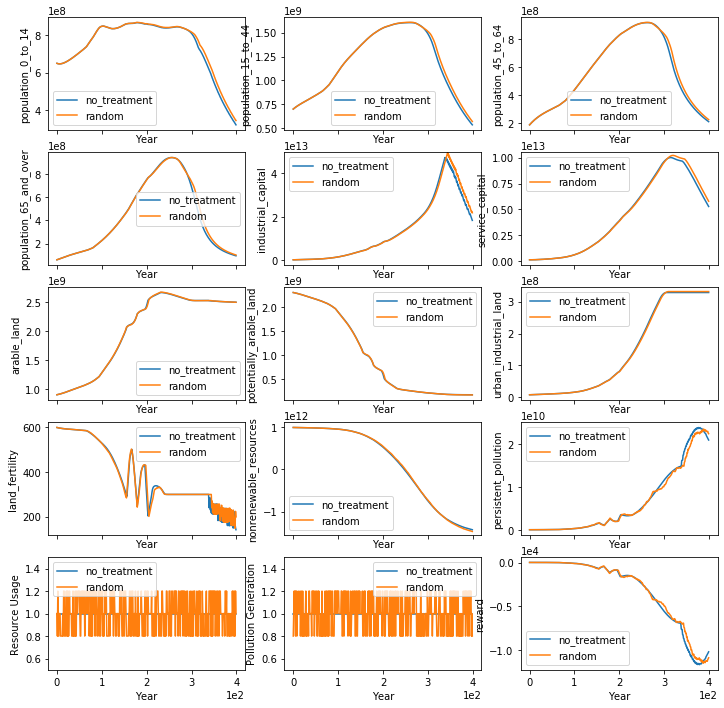

In [7]:
policies = {
    "no_treatment": NoTreatmentPolicy(),
    "random": RandomPolicy(),
}
plot_sample_trajectory(policies)